In [61]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sb


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,accuracy_score


# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Station

In [2]:
##import csv file
df_station = pd.read_csv('D:\\UCD\\Semester-2\\SoftwareEngineering\\Dublin-Bikes\\ML\\station.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, encoding='Windows-1252')
df_station

,number,contract_name,name,address,bike_stands,bonus,position_lat,position_lng,banking
0,1,dublin,CLARENDON ROW,Clarendon Row,31,0,53.340927,-6.262501,0
1,2,dublin,BLESSINGTON STREET,Blessington Street,20,0,53.356769,-6.268140,0
2,3,dublin,BOLTON STREET,Bolton Street,20,0,53.351182,-6.269859,0
3,4,dublin,GREEK STREET,Greek Street,20,0,53.346874,-6.272976,0
4,5,dublin,CHARLEMONT PLACE,Charlemont Street,40,0,53.330662,-6.260177,0
...,...,...,...,...,...,...,...,...,...
109,114,dublin,WILTON TERRACE (PARK),Wilton Terrace (Park),40,0,53.333653,-6.248345,0
110,115,dublin,KILLARNEY STREET,Killarney Street,30,0,53.354845,-6.247579,0
111,116,dublin,BROADSTONE,Broadstone,30,0,53.354700,-6.272314,0
112,117,dublin,HANOVER QUAY EAST,Hanover Quay East,40,0,53.343653,-6.231755,0


In [3]:
#these feature is not necessary for predicting in later. We can use feature 'number' to idnetify each stating
df_station = df_station.drop(['contract_name','address','bonus','position_lng','position_lat','banking'], axis=1)
#show data type
df_station.dtypes

number          int64
name           object
bike_stands     int64
dtype: object

In [4]:
#modify data type
df_station['name'] = df_station['name'].astype('category')

# Availability

In [5]:
df_availability = pd.read_csv('D:\\UCD\\Semester-2\\SoftwareEngineering\\Dublin-Bikes\\ML\\availability.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, encoding='Windows-1252')
df_availability

,number,last_update,available_bike_stands,available_bikes,status
0,1,1677714317000,22,9,OPEN
1,1,1677715585000,23,8,OPEN
2,1,1677716205000,24,7,OPEN
3,1,1677716440000,25,6,OPEN
4,1,1677717012000,25,6,OPEN
...,...,...,...,...,...
626942,117,1680596207000,0,39,OPEN
626943,117,1680596485000,0,40,OPEN
626944,117,1680597040000,0,40,OPEN
626945,117,1680597650000,1,39,OPEN


In [6]:
df_availability.dtypes

number                    int64
last_update               int64
available_bike_stands     int64
available_bikes           int64
status                   object
dtype: object

In [7]:
#Converting the time format once again for subsequent merging of dataset
df_availability['last_update']=pd.to_datetime(df_availability['last_update'], unit='ms')
df_availability['last_update']=df_availability['last_update'].astype('datetime64[ns]')
df_availability

,number,last_update,available_bike_stands,available_bikes,status
0,1,2023-03-01 23:45:17,22,9,OPEN
1,1,2023-03-02 00:06:25,23,8,OPEN
2,1,2023-03-02 00:16:45,24,7,OPEN
3,1,2023-03-02 00:20:40,25,6,OPEN
4,1,2023-03-02 00:30:12,25,6,OPEN
...,...,...,...,...,...
626942,117,2023-04-04 08:16:47,0,39,OPEN
626943,117,2023-04-04 08:21:25,0,40,OPEN
626944,117,2023-04-04 08:30:40,0,40,OPEN
626945,117,2023-04-04 08:40:50,1,39,OPEN


In [8]:
#modify data type
df_availability['status'] = df_availability['status'].astype('category')
    
intCols = df_availability.select_dtypes(['int64']).columns
for i in intCols:
    df_availability[i] = df_availability[i].astype('Int64')
df_availability.dtypes

number                            Int64
last_update              datetime64[ns]
available_bike_stands             Int64
available_bikes                   Int64
status                         category
dtype: object

In [9]:
#Based on life experience, the use of shared bicycles may be related to the time period. If it is not useful for predicting, we can drop them or do not use them
#according to datesecond column to classify them
conditions = [
    ((df_availability['last_update'].dt.strftime('%H') >= '07') & (df_availability['last_update'].dt.strftime('%H') <= '10')),
    ((df_availability['last_update'].dt.strftime('%H') >= '11') & (df_availability['last_update'].dt.strftime('%H') <= '14')),
    ((df_availability['last_update'].dt.strftime('%H') >= '15') & (df_availability['last_update'].dt.strftime('%H') <= '18')),
    ((df_availability['last_update'].dt.strftime('%H') >= '19') & (df_availability['last_update'].dt.strftime('%H') <= '22')),
    ((df_availability['last_update'].dt.strftime('%H') >= '23') | (df_availability['last_update'].dt.strftime('%H') <= '02')),
    ((df_availability['last_update'].dt.strftime('%H') >= '03') & (df_availability['last_update'].dt.strftime('%H') <= '06'))    
]

values = ['Morning', 'Noon', 'Afternoon','Early Evening', 'Midnight','Early Morning']
df_availability['timeInterval']  = np.select(conditions, values)

In [10]:
#Possible duplicate rows need to be removed
df_availability = df_availability.drop_duplicates()
df_availability

,number,last_update,available_bike_stands,available_bikes,status,timeInterval
0,1,2023-03-01 23:45:17,22,9,OPEN,Midnight
1,1,2023-03-02 00:06:25,23,8,OPEN,Midnight
2,1,2023-03-02 00:16:45,24,7,OPEN,Midnight
3,1,2023-03-02 00:20:40,25,6,OPEN,Midnight
4,1,2023-03-02 00:30:12,25,6,OPEN,Midnight
...,...,...,...,...,...,...
626942,117,2023-04-04 08:16:47,0,39,OPEN,Morning
626943,117,2023-04-04 08:21:25,0,40,OPEN,Morning
626944,117,2023-04-04 08:30:40,0,40,OPEN,Morning
626945,117,2023-04-04 08:40:50,1,39,OPEN,Morning


# Weather

In [11]:
#import weather data
df_weather = pd.read_csv('D:\\UCD\\Semester-2\\SoftwareEngineering\\Dublin-Bikes\\ML\\weather.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, encoding='Windows-1252')
df_weather

,datetime,tempmax,temp,tempmin,feelslikemax,feelslike,feelslikemin,precip,precipprob,precipcover,preciptype,humidity,visibility,windspeed,winddir,conditions,sunrise,sunset
0,0000-00-00 00:00:00,12.8,9.1,5.7,12.8,7.8,3.0,0.002,100.0,8.33,rain,72.30,18.9,27.9,180.2,"Rain, Partially cloudy",06:52:05,20:05:12
1,2023-02-07 00:00:00,9.8,7.3,4.1,8.0,5.3,2.4,0.000,0.0,0.00,NaN,81.60,19.8,16.0,219.4,Partially cloudy,07:59:34,17:19:29
2,2023-02-08 00:00:00,9.0,6.6,4.3,5.6,3.5,0.8,0.000,0.0,0.00,NaN,79.80,19.0,28.4,221.3,Partially cloudy,07:57:42,17:21:27
3,2023-02-09 00:00:00,8.0,4.5,1.1,4.8,1.2,-3.0,0.092,100.0,4.17,rain,75.80,19.5,23.8,244.3,"Rain, Partially cloudy",07:55:48,17:23:26
4,2023-02-10 00:00:00,11.2,8.2,4.0,11.2,6.0,0.8,0.001,100.0,4.17,rain,83.20,16.7,28.5,236.8,"Rain, Partially cloudy",07:53:53,17:25:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,2023-04-21 19:00:00,12.2,10.9,4.8,12.2,10.9,2.3,0.100,9.5,8.33,rain,71.25,24.1,16.2,256.4,Overcast,06:12:46,20:36:01
1128,2023-04-21 20:00:00,12.2,9.9,4.8,12.2,7.7,2.3,0.000,4.8,8.33,NaN,76.35,24.1,15.4,254.0,Overcast,06:12:46,20:36:01
1129,2023-04-21 21:00:00,12.2,8.9,4.8,12.2,6.7,2.3,0.000,4.8,8.33,NaN,81.85,24.1,14.5,251.6,Overcast,06:12:46,20:36:01
1130,2023-04-21 22:00:00,12.2,8.0,4.8,12.2,5.6,2.3,0.000,4.8,8.33,NaN,87.79,24.1,13.7,249.2,Overcast,06:12:46,20:36:01


In [12]:
#drop redundant features
df_weather = df_weather.drop(['tempmax','tempmin','feelslikemax','feelslike','feelslikemin','precip','precipprob','preciptype','precipcover','winddir','sunrise','sunset'],axis=1)
df_weather = df_weather.drop(df_weather.index[0])

In [13]:
df_weather.dtypes

datetime       object
temp          float64
humidity      float64
visibility    float64
windspeed     float64
conditions     object
dtype: object

In [14]:
#modify data type
df_weather['conditions'] = df_weather['conditions'].astype('category')
df_weather['datetime'] = df_weather['datetime'].astype('datetime64[ns]')
df_weather.dtypes

datetime      datetime64[ns]
temp                 float64
humidity             float64
visibility           float64
windspeed            float64
conditions          category
dtype: object

In [15]:
#Possible duplicate rows need to be removed
df_weather = df_weather.drop_duplicates()
df_weather

,datetime,temp,humidity,visibility,windspeed,conditions
1,2023-02-07 00:00:00,7.3,81.60,19.8,16.0,Partially cloudy
2,2023-02-08 00:00:00,6.6,79.80,19.0,28.4,Partially cloudy
3,2023-02-09 00:00:00,4.5,75.80,19.5,23.8,"Rain, Partially cloudy"
4,2023-02-10 00:00:00,8.2,83.20,16.7,28.5,"Rain, Partially cloudy"
5,2023-02-11 00:00:00,8.6,77.30,19.1,13.5,"Rain, Partially cloudy"
...,...,...,...,...,...,...
1127,2023-04-21 19:00:00,10.9,71.25,24.1,16.2,Overcast
1128,2023-04-21 20:00:00,9.9,76.35,24.1,15.4,Overcast
1129,2023-04-21 21:00:00,8.9,81.85,24.1,14.5,Overcast
1130,2023-04-21 22:00:00,8.0,87.79,24.1,13.7,Overcast


### Merge files
For predicting, we need to merge them dataset.

In [16]:
#merge station and availability of each station based on station number.
df_station_availability = pd.merge(df_station,df_availability,on='number')
df_station_availability

,number,name,bike_stands,last_update,available_bike_stands,available_bikes,status,timeInterval
0,1,CLARENDON ROW,31,2023-03-01 23:45:17,22,9,OPEN,Midnight
1,1,CLARENDON ROW,31,2023-03-02 00:06:25,23,8,OPEN,Midnight
2,1,CLARENDON ROW,31,2023-03-02 00:16:45,24,7,OPEN,Midnight
3,1,CLARENDON ROW,31,2023-03-02 00:20:40,25,6,OPEN,Midnight
4,1,CLARENDON ROW,31,2023-03-02 00:30:12,25,6,OPEN,Midnight
...,...,...,...,...,...,...,...,...
621611,117,HANOVER QUAY EAST,40,2023-04-04 08:16:47,0,39,OPEN,Morning
621612,117,HANOVER QUAY EAST,40,2023-04-04 08:21:25,0,40,OPEN,Morning
621613,117,HANOVER QUAY EAST,40,2023-04-04 08:30:40,0,40,OPEN,Morning
621614,117,HANOVER QUAY EAST,40,2023-04-04 08:40:50,1,39,OPEN,Morning


In [17]:
#In order to merge the above dataset with the weather dataset, we need to add a new column and merge the two datasets based on that column. Adding a new column can avoid affecting the original dataset.
#This is because the weather data is updated every hour, but the station data is updated irregularly. So we have to make the station update time a whole hour.
df_station_availability['datetime'] = df_station_availability['last_update'].dt.floor('H')
df_station_availability

,number,name,bike_stands,last_update,available_bike_stands,available_bikes,status,timeInterval,datetime
0,1,CLARENDON ROW,31,2023-03-01 23:45:17,22,9,OPEN,Midnight,2023-03-01 23:00:00
1,1,CLARENDON ROW,31,2023-03-02 00:06:25,23,8,OPEN,Midnight,2023-03-02 00:00:00
2,1,CLARENDON ROW,31,2023-03-02 00:16:45,24,7,OPEN,Midnight,2023-03-02 00:00:00
3,1,CLARENDON ROW,31,2023-03-02 00:20:40,25,6,OPEN,Midnight,2023-03-02 00:00:00
4,1,CLARENDON ROW,31,2023-03-02 00:30:12,25,6,OPEN,Midnight,2023-03-02 00:00:00
...,...,...,...,...,...,...,...,...,...
621611,117,HANOVER QUAY EAST,40,2023-04-04 08:16:47,0,39,OPEN,Morning,2023-04-04 08:00:00
621612,117,HANOVER QUAY EAST,40,2023-04-04 08:21:25,0,40,OPEN,Morning,2023-04-04 08:00:00
621613,117,HANOVER QUAY EAST,40,2023-04-04 08:30:40,0,40,OPEN,Morning,2023-04-04 08:00:00
621614,117,HANOVER QUAY EAST,40,2023-04-04 08:40:50,1,39,OPEN,Morning,2023-04-04 08:00:00


In [18]:
#merge the above dataframe and the weather dataframe based on time
df = pd.merge(df_station_availability, df_weather, on='datetime',how='outer')
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
df

,number,name,bike_stands,last_update,available_bike_stands,available_bikes,status,timeInterval,datetime,temp,humidity,visibility,windspeed,conditions
0,1.0,CLARENDON ROW,31.0,2023-03-01 23:45:17,22,9,OPEN,Midnight,2023-03-01 23:00:00,NaN,NaN,NaN,NaN,NaN
1,2.0,BLESSINGTON STREET,20.0,2023-03-01 23:43:59,0,20,OPEN,Midnight,2023-03-01 23:00:00,NaN,NaN,NaN,NaN,NaN
2,3.0,BOLTON STREET,20.0,2023-03-01 23:48:21,11,9,OPEN,Midnight,2023-03-01 23:00:00,NaN,NaN,NaN,NaN,NaN
3,3.0,BOLTON STREET,20.0,2023-03-01 23:58:27,11,9,OPEN,Midnight,2023-03-01 23:00:00,NaN,NaN,NaN,NaN,NaN
4,4.0,GREEK STREET,20.0,2023-03-01 23:47:55,19,1,OPEN,Midnight,2023-03-01 23:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622057,NaN,NaN,NaN,NaT,<NA>,<NA>,NaN,NaN,2023-04-21 19:00:00,10.9,71.25,24.1,16.2,Overcast
622058,NaN,NaN,NaN,NaT,<NA>,<NA>,NaN,NaN,2023-04-21 20:00:00,9.9,76.35,24.1,15.4,Overcast
622059,NaN,NaN,NaN,NaT,<NA>,<NA>,NaN,NaN,2023-04-21 21:00:00,8.9,81.85,24.1,14.5,Overcast
622060,NaN,NaN,NaN,NaT,<NA>,<NA>,NaN,NaN,2023-04-21 22:00:00,8.0,87.79,24.1,13.7,Overcast


There are some rows and columns have null values. The reason is weather dataset with forecasts for the next 14 days but the station dataset does not have them.

In [19]:
#delete the rows which includes null values
df = df.dropna(subset=['temp'])
df = df.dropna(subset=['name'])
df['number'] = df['number'].astype('Int64')
df['available_bikes'] = df['available_bikes'].astype('Int64')
df['available_bike_stands'] = df['available_bike_stands'].astype('Int64')
df['bike_stands'] = df['bike_stands'].astype('Int64')
df

,number,name,bike_stands,last_update,available_bike_stands,available_bikes,status,timeInterval,datetime,temp,humidity,visibility,windspeed,conditions
143,1,CLARENDON ROW,31,2023-03-02 00:06:25,23,8,OPEN,Midnight,2023-03-02 00:00:00,5.7,83.40,18.1,21.3,"Rain, Partially cloudy"
144,1,CLARENDON ROW,31,2023-03-02 00:16:45,24,7,OPEN,Midnight,2023-03-02 00:00:00,5.7,83.40,18.1,21.3,"Rain, Partially cloudy"
145,1,CLARENDON ROW,31,2023-03-02 00:20:40,25,6,OPEN,Midnight,2023-03-02 00:00:00,5.7,83.40,18.1,21.3,"Rain, Partially cloudy"
146,1,CLARENDON ROW,31,2023-03-02 00:30:12,25,6,OPEN,Midnight,2023-03-02 00:00:00,5.7,83.40,18.1,21.3,"Rain, Partially cloudy"
147,1,CLARENDON ROW,31,2023-03-02 00:40:18,25,6,OPEN,Midnight,2023-03-02 00:00:00,5.7,83.40,18.1,21.3,"Rain, Partially cloudy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621610,117,HANOVER QUAY EAST,40,2023-04-04 08:10:27,3,36,OPEN,Morning,2023-04-04 08:00:00,8.0,75.85,10.0,11.2,Partially cloudy
621611,117,HANOVER QUAY EAST,40,2023-04-04 08:16:47,0,39,OPEN,Morning,2023-04-04 08:00:00,8.0,75.85,10.0,11.2,Partially cloudy
621612,117,HANOVER QUAY EAST,40,2023-04-04 08:21:25,0,40,OPEN,Morning,2023-04-04 08:00:00,8.0,75.85,10.0,11.2,Partially cloudy
621613,117,HANOVER QUAY EAST,40,2023-04-04 08:30:40,0,40,OPEN,Morning,2023-04-04 08:00:00,8.0,75.85,10.0,11.2,Partially cloudy


In [20]:
#delete the reference column on merge.
df = df.drop(['datetime'],axis=1)

In [21]:
#rename
df = df.rename(columns={'last_update':'datetime'})

In [22]:
#accoring to the category column to generate a numeric column
conditions = [(df['conditions'] == 'Rain, Partially cloudy'),
             (df['conditions'] == 'Overcast'),
             (df['conditions'] == 'Partially cloudy'),
             (df['conditions'] == 'Snow, Partially cloudy'),
             (df['conditions'] == 'Snow, Rain, Overcast'),
             (df['conditions'] == 'Snow, Overcast'),
             (df['conditions'] == 'Rain, Overcast'),
             (df['conditions'] == 'Snow, Rain, Partially cloudy'),
             (df['conditions'] == 'Clear')
]

values = ['1','2','3','4','5','6','7','8','9']
df['conditionTypes'] = np.select(conditions,values)
df['conditionTypes'] = df['conditionTypes'].astype('Int64')

In [23]:
conditions = [(df['timeInterval'] == 'Midnight'),
             (df['timeInterval'] == 'Early Morning'),
             (df['timeInterval'] == 'Morning'),
             (df['timeInterval'] == 'Noon'),
             (df['timeInterval'] == 'Snow, Rain, Overcast'),
             (df['timeInterval'] == 'Snow, Overcast'),
             (df['timeInterval'] == 'Rain, Overcast'),
             (df['timeInterval'] == 'Snow, Rain, Partially cloudy'),
             (df['timeInterval'] == 'Clear')
]

values = ['1','2','3','4','5','6','7','8','9']
df['timeIntervalTypes'] = np.select(conditions,values)
df['timeIntervalTypes'] = df['conditionTypes'].astype('Int64')

In [24]:
#create column for day of the week
#The usage of bikes is different in weekday and weekend
df['weekday'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['weekday'].astype('Int64')
df['hour'] = df['hour'].astype('Int64')
df

,number,name,bike_stands,datetime,available_bike_stands,available_bikes,status,timeInterval,temp,humidity,visibility,windspeed,conditions,conditionTypes,timeIntervalTypes,weekday,hour
143,1,CLARENDON ROW,31,2023-03-02 00:06:25,23,8,OPEN,Midnight,5.7,83.40,18.1,21.3,"Rain, Partially cloudy",1,1,3,0
144,1,CLARENDON ROW,31,2023-03-02 00:16:45,24,7,OPEN,Midnight,5.7,83.40,18.1,21.3,"Rain, Partially cloudy",1,1,3,0
145,1,CLARENDON ROW,31,2023-03-02 00:20:40,25,6,OPEN,Midnight,5.7,83.40,18.1,21.3,"Rain, Partially cloudy",1,1,3,0
146,1,CLARENDON ROW,31,2023-03-02 00:30:12,25,6,OPEN,Midnight,5.7,83.40,18.1,21.3,"Rain, Partially cloudy",1,1,3,0
147,1,CLARENDON ROW,31,2023-03-02 00:40:18,25,6,OPEN,Midnight,5.7,83.40,18.1,21.3,"Rain, Partially cloudy",1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621610,117,HANOVER QUAY EAST,40,2023-04-04 08:10:27,3,36,OPEN,Morning,8.0,75.85,10.0,11.2,Partially cloudy,3,3,1,8
621611,117,HANOVER QUAY EAST,40,2023-04-04 08:16:47,0,39,OPEN,Morning,8.0,75.85,10.0,11.2,Partially cloudy,3,3,1,8
621612,117,HANOVER QUAY EAST,40,2023-04-04 08:21:25,0,40,OPEN,Morning,8.0,75.85,10.0,11.2,Partially cloudy,3,3,1,8
621613,117,HANOVER QUAY EAST,40,2023-04-04 08:30:40,0,40,OPEN,Morning,8.0,75.85,10.0,11.2,Partially cloudy,3,3,1,8


In [83]:
df.dtypes

number                            Int64
name                           category
bike_stands                       Int64
datetime                 datetime64[ns]
available_bike_stands             Int64
available_bikes                   Int64
status                         category
timeInterval                     object
temp                            float64
humidity                        float64
visibility                      float64
windspeed                       float64
conditions                     category
conditionTypes                    Int64
timeIntervalTypes                 Int64
weekday                           Int64
hour                              Int64
dtype: object

In [35]:
df.columns

Index(['number', 'name', 'bike_stands', 'datetime', 'available_bike_stands',
       'available_bikes', 'status', 'timeInterval', 'temp', 'humidity',
       'visibility', 'windspeed', 'conditions', 'conditionTypes',
       'timeIntervalTypes', 'weekday', 'hour'],
      dtype='object')

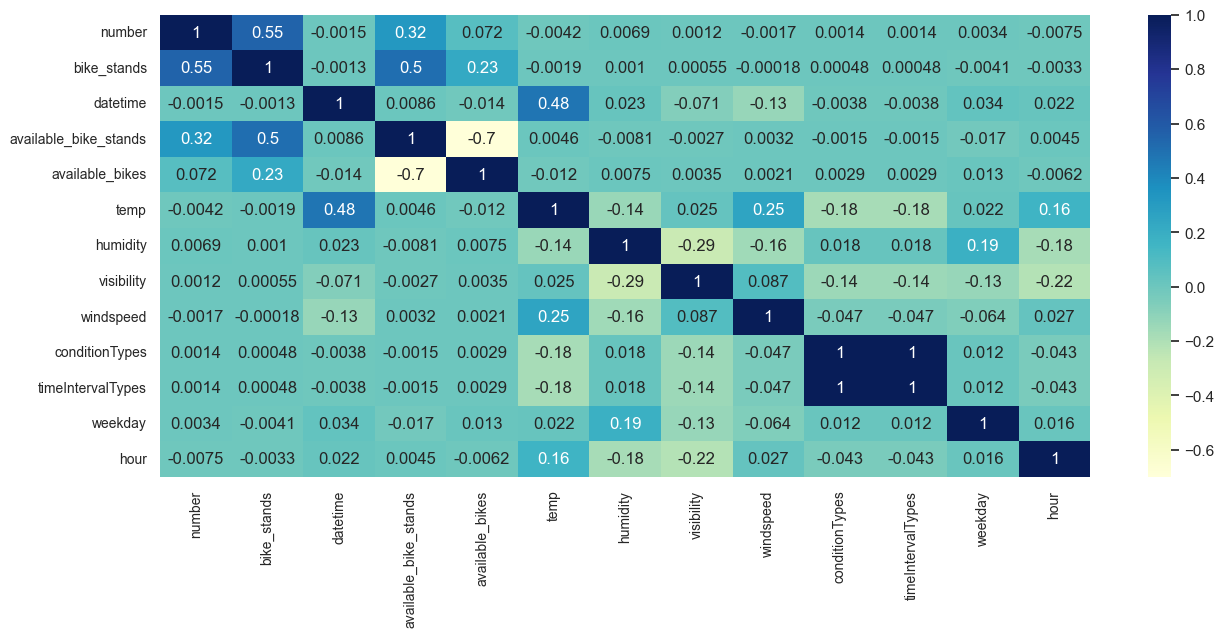

In [54]:
plt.figure(figsize=(15, 6))
dataplot = sb.heatmap(df[['number', 'bike_stands', 'datetime', 'available_bike_stands',
       'available_bikes',  'temp', 'humidity',
       'visibility', 'windspeed',  'conditionTypes',
       'timeIntervalTypes', 'weekday', 'hour']].corr(), cmap="YlGnBu", annot=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# displaying heatmap
plt.show()

In [84]:
#using logical logistic regression model
def stations_logistic_model(stationNo):
    # Prepare the descriptive features
    # The selected features will all have a significant impact on the use of the bicycle.
    cont_features = ['number','temp', 'windspeed', 'visibility','humidity','weekday','conditionTypes','hour']

    #accoring to station No to generate a model
    temp_df = df.loc[df['number'] == stationNo]

    X = temp_df[cont_features]
    y = temp_df['available_bike_stands']
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train aka fit, a model using all continuous features.
    logistic = LogisticRegression().fit(X_train,y_train)
    predictions = logistic.predict(X)
    #calculate the accuracy of this model
    accuracy = accuracy_score(y,predictions)
    return accuracy

In [85]:
number = df['number'].unique()
number

<IntegerArray>
[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
 ...
 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
Length: 113, dtype: Int64

In [86]:
accuracy = 0
for num in number:
    accuracy += stations_logistic_model(num)
    
print("The average accuracy of all stations' prediction : ",accuracy / len(number))

The average accuracy of all stations' prediction :  0.1706786432689902


Because the target feature and other feature is not linear relationship. If we use linear regression model, we will get uncorrect output.<br>
Then I use logistic regression model to predict target feature. The average accuracy of all station is too low just 0.17.<br>
Therefore, Linear regression and logistic regression are not proper model in this case. Next, I will use Random Forest Regression model to try again.

In [1]:
#define a function to train every station using random forest regression model and save the trained model in a pickle file
def stations_randomForest_model(stationNo):
    # Prepare the descriptive features
    # The selected features will all have a significant impact on the use of the bicycle.
    cont_features = ['number','temp', 'windspeed', 'visibility','humidity','weekday','conditionTypes','hour']

    #accoring to station No to generate a model
    temp_df = df.loc[df['number'] == stationNo]

    X = temp_df[cont_features]
    y = temp_df[['available_bike_stands','available_bikes']]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train aka fit, a model using all continuous features.
    forest = RandomForestRegressor(n_estimators=90, random_state=42).fit(X_train,y_train)
    #save each model to a pickle file
    fileName = "stationNo" + str(stationNo) + ".pkl"
    with open(fileName,'wb') as handle:
        pickle.dump(forest, handle, protocol=pickle.HIGHEST_PROTOCOL)
    predictions = forest.predict(X)
    print("\nPredictions with linear regression: \n")
    actual_vs_predicted_ranreg = pd.concat([y, pd.DataFrame(predictions, columns=['Predicted_available_stands','Predicted_available_bikes'], index=y.index)], axis=1)
    print(actual_vs_predicted_ranreg)
    return mean_absolute_error(y, predictions)

In [89]:
#Display each station predictions and save the model file as pkl format
mae = 0
for num in number:
    # print('Station No.', num)
    mae += stations_randomForest_model(num)
    
print("The average Mean Absolute Error of all stations: ", mae/len(number))


Predictions with linear regression: 

        available_bike_stands  available_bikes  Predicted_available_stands   
143                        23                8                   24.479371  \
144                        24                7                   24.479371   
145                        25                6                   24.479371   
146                        25                6                   24.479371   
147                        25                6                   24.479371   
...                       ...              ...                         ...   
620793                      8               23                    8.532280   
620794                      8               23                    8.532280   
620795                      9               22                    8.532280   
620796                      8               23                    8.532280   
620797                      5               26                    8.532280   

        Predicted_availa

We can see from the above data that the difference between the predicted and actual values is very small at 0.7. I consider this value of difference to be acceptable and within the permitted range. It means that Random Forest Regression model shows higher accuracy and performance in this case. We decide to use Random Forest Regression Model.

In [ ]:
#Test model
# Load the trained model
with open('D:\\UCD\\Semester-2\\SoftwareEngineering\\Dublin-Bikes\\ML\\stationNo1.pkl','rb') as file:
    model = pickle.load(file)

#input parameters
#parameter name:  ['number','temp', 'windspeed', 'visibility','humidity','weekday','conditionTypes','hour']
predicted  = model.predict([[2,5.1,21.3,18.1,83.4,3,1,0]])
predicted

Comparing with the actual data, the predicted data is reasonable.